**Overview of Section**

This section will explore what *torch.nn* does in function when creating neural networks. First, this section will create a neural network from scratch. We will be using the MNIST_Dataset to train the model on without using any of the utilities of *torch.nn*, *torch.optim*, *Dataset*, and *DataLoader*. Afterwards, we will gradually refactor the code to include per module. 

**MNIST Data Setup**

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

Here we are utilizing *pathlib* to create a directory for our MNIST dataset that we will download using *requests*

In [2]:
import pickle
import gzip

with gzip.open((PATH/FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

The dataset is in a numpy array format, not a tensor, and is stored using pickle, a python-specific format for serializing data.

Since we're dealing with images, we have pixel values in the shape of 28x28. This is currently being stored as a flattened row of length 784 (28x28). Let's put this back into it's proper dimensions.

In [3]:
from matplotlib import pyplot
import numpy as np

x_train[0].shape

(784,)

In [4]:
z = x_train[0].reshape((28,28))
x_train[0].shape, x_train.reshape

((784,), <function ndarray.reshape>)

Remember that we are working with NumPy arrays and not PyTorch tensors. There is a similiar function for reshape on both PyTorch & NumPy. So, if we try to use *.view()* which is a PyTorch exclusive function, it wouldn't work.

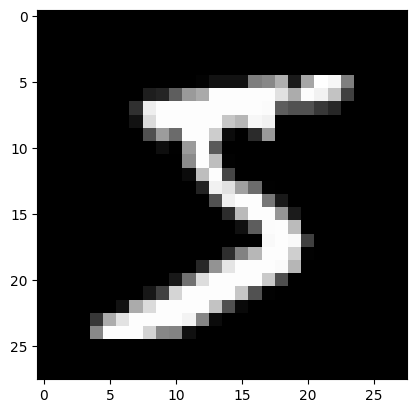

In [5]:
pyplot.imshow(z, cmap="gray")

In [6]:
print(x_train.shape) 

(50000, 784)


As we can see, we have 50000 images with 784 pixel cells. Each row is an image while each column is the corresponding pixel values for that specific image in that row. Now, we need to convert these to *torch.tensor*

In [7]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


**Neural Network From Scratch**

We'll be creating a model with nothin but PyTorch tensor operations. We will be utilizing PyTorch's methods to create random or zero-filled tensors which we will be using to create the weights and bias for a simple linear model. Same thing as before, we'll also be telling PyTorch to require teh gradients for these so that it can track all the operations done on the tensor. This is so that we can do backpropagation later on.

In [8]:
import math
# Utilizing Xavier initialisation
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

What's Xavier initialisation? This is so that the random values generated by *torch.randn* aren't too far apart. Having values that are too high or too low can cause issues with the gradients so we do Xavier initialisation so that all the values are within a certain range of distribution. Basically, we have 784 neurons. We get the square root of 784 which is then used as a part of the scaling factor for all the values that is generated by randn for the weights. This is for normal distribution which we have. If we have a uniformed distribution then we would also use the out_features (10). But in this case that's not needed.

Since PyTorch can automatically calculate gradients, we can use any standard Python funcion as model. Here, let's write a standard plain matrix multiplicaton and broadcasted addition to create a simple linear model. We'll also need an activation function so log_softmax is what we'll be using. 

It's important to remember that while PyTorch provies a lot of prewritten loss and activtion functions, it is relatively easy for you to make your own custom functions as well using play Python. PyTorch will even create fast GPU or vectorized CPU code to make it run automatically. 

**NOTE:** *requires_grad_()* and *requires_grad=True* both apply the tracking of gradients for the tensors that they are assigned on. It just so that these two are applied differently. *requires_gad_()* is done on existing tensors while *requires_grad=True* is done on tensors that are being created.

In [9]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

We specify log_softmax because that is an activation function that we will use for this model. Compared to before, in the Workflow chapter. We only used a (one) linear layer without any additions whatsoever. Here, we've added an activation function similiar to ReLU (similiar in the sense that they are both activation functions). In this case, it's a log_softmax function because that does well when dealing with classificaiton tasks.

log_softmax outputs a set of probabilities, and since we're dealing with the MNIST_Dataset and we want to identify which number is an input from 0-9 then this activtion function is exactly what we need. So basically. 

Linear Layer (xb @ weights + bias) + Activation Function (log_softmax). That's the composition of our model.

In [10]:
bs = 64 # batchsize
xb = x_train[0:bs]

preds = model(xb)
print(preds[0], preds.shape)

tensor([-2.1927, -2.6379, -2.4251, -2.5838, -2.3804, -2.1210, -1.9880, -2.2527,
        -2.3012, -2.3199], grad_fn=<SelectBackward0>) torch.Size([64, 10])


As seen here, we have PyTorch actively tracking the preds tensor. Since we already have our data and model, let's start working on a loss function. Here we are using a custom function that will calculate the negative log-likelihood. It's a bit of a mouthful but the most important part is that this is a good loss function to work alongside our activation function earlier.

We split our training data into different batches, in this case we specify the first 64 items in the x_train dataset.

**FOR SEMI-DEEP EXPLANATION**

Remember that *log_softmax* outputs the logarithm of the probabilities for each class. If we apply *torch.exp()* to the outputs of *log_softmax*, we would get the original probabilities, similar to if we used *softmax* alone. These probabilities can then be converted to percentages to see the model’s confidence in each class. However, right now, we need to measure how wrong our model is, so we use a loss function, which is the *negative log-likelihood* or *nll*.

The most important thing to understand is that logarithms are often used for classification tasks, and since we’re dealing with logarithms, we also need a loss function that can handle these logarithms effectively. That’s why the negative log-likelihood is important—it works directly with the log probabilities output by log_softmax.

**NOTES:**

1. The log probabilities we are dealing with are negative because they are the logarithms of probabilities, which are numbers between 0 and 1
2. Logarithms are closely related to limits, especially in the context of calculus and continuous functions.
3. ‘Negating’ in the context of nll means we are multiplying the log probabilities by -1 as part of the loss calculation process.

In [11]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Let's take a look at our loss with the model that we created.

In [12]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3760, grad_fn=<NegBackward0>)


Now that we have our loss function working, let's make a metric for our consumption. We'll create an accuracy metric. The idea to it is pretty simple. If the index with the largest value matches the target value then the prediction will be correct. Quite simple.

In [13]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    print(preds, len(preds))
    return (preds == yb).float().mean()

In [14]:
print(preds, len(preds))

tensor([[-2.1927, -2.6379, -2.4251, -2.5838, -2.3804, -2.1210, -1.9880, -2.2527,
         -2.3012, -2.3199],
        [-2.4099, -2.6653, -2.3391, -2.1723, -2.0901, -2.4053, -2.3722, -2.1739,
         -2.1428, -2.3856],
        [-1.8791, -2.5442, -2.4632, -2.1490, -2.7839, -2.2268, -2.3421, -2.2445,
         -2.3242, -2.3296],
        [-2.1576, -2.1659, -2.0665, -2.0633, -2.6236, -2.9105, -2.5997, -1.9282,
         -2.2168, -2.8062],
        [-2.1189, -2.1379, -2.3394, -2.3604, -2.4416, -2.7262, -1.9230, -2.3200,
         -2.4977, -2.3864],
        [-2.5518, -2.2202, -2.4187, -2.2214, -2.1542, -2.4181, -2.0672, -2.3424,
         -2.4448, -2.2877],
        [-2.0097, -2.4755, -2.1304, -2.0972, -2.2250, -2.6348, -2.4882, -2.4458,
         -2.4677, -2.2446],
        [-2.3043, -2.2724, -2.4020, -2.2489, -2.4098, -2.8954, -1.7130, -2.3383,
         -2.5456, -2.2955],
        [-2.3398, -2.3758, -2.1362, -2.1261, -2.3170, -2.5031, -2.4144, -2.3064,
         -2.3284, -2.2404],
        [-2.0162, -

In [15]:
accur = accuracy(preds, yb)
print(accur)

tensor([6, 4, 0, 7, 6, 6, 0, 6, 3, 0, 0, 4, 1, 9, 3, 6, 6, 6, 2, 6, 6, 7, 0, 7,
        3, 1, 0, 6, 9, 1, 0, 3, 4, 6, 6, 0, 4, 3, 0, 9, 3, 1, 3, 0, 0, 6, 6, 0,
        6, 0, 3, 6, 6, 0, 6, 6, 6, 6, 0, 7, 9, 3, 7, 6]) 64
tensor(0.0156)


Remember that argmax takes the index of the maximum value. If you inspect both the preds and the accur tensors. You can see that the outputs of the accur tensor are the indexes from the preds tensor that have the highest value / closest to 0 since all are in the negatives.

When it comes to the optimizer, we're just going to do that manually. Remember that gradient descent's formula *weights -= weights.grad * lr*. In this case, we're not doing random batch sizes so what we're doing here is called mini-batch gradient descent. If we wanted to do stochastic gradient descent manually, we would have to shuffle the data randomly and split it into batches. Here, we're not doing the shuffle part. At the end of the day, the optimizer is just gradient descent. There's just many types of gradient descent. We can do these manually or using the PyTorch library. We're doing the latter for now.

Now that we have everything we need, let's do the training loop:

1. Select mini-batch of data of size (bs - 64)
2. Generate predictions with the model (forward-pass)
3. Calculate the loss of these predictions
4. Conduct backpropagation with *loss.backward()* (backward-pass)
5. Step the weights & bias

Remember that N is a variable that holds the number of images that we have: N = 5000

However, before we start we need a way to ensure that our total number of images *n* is divisible by our batchsize. That way we can account for the total number of batche sizes we need. This can easily be done by this formula: *((n - 1) // bs + 1)*. In addition, this formula also accounts for adding an extra batch if the total number of images is NOT divisible by the batchsize. This helps include all the remaining images. The last batchsize would differ depending on the amount of images left. 

Breaking it down:

1. **(n - 1)** - this provides for the case if n is divisible by bs. If it is divisible, you won't get an additional unecessary batch. 
2. **//** - in simplest terms, this just divides n by bs. Double slash means that you'll get a whole number.
3. **bs + 1** - this always creates an extra batch so that it can handle all the extra images that you might have left out. Unless if n is divisible by the batchsize then this just provides the last batch that you need.

Let's see this in action:

In [16]:
def calcBatchNum(images, batchsize):
    imTotal = images - 1
    bsCalc = imTotal // batchsize
    bsLast = imTotal % batchsize
    bsTotal = bsCalc + 1
    print(f"Image Total: {imTotal} | Batch Division: {bsCalc} | Image in Last Batch: {bsLast} | Batch Total: {bsTotal}")

In [17]:
calcBatchNum(n, bs)
calcBatchNum(50000, 50)

Image Total: 49999 | Batch Division: 781 | Image in Last Batch: 15 | Batch Total: 782
Image Total: 49999 | Batch Division: 999 | Image in Last Batch: 49 | Batch Total: 1000


Here we can see that if the batch division is 64 (5000 is not divisible by 64), it would originally have only 781 batches leaving out the 15 images not to be included. However, we've in our batch total, we've added an extra so these are automatically placed in the last batch. 

In [18]:
lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):

        # Setting Start Batch
        start_i = i * bs
        # Setting End Batch
        end_i = start_i + bs

        # Applying Batchsize to Data
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]

        # Create Predictions By Model & Loss From Predictions
        pred = model(xb)
        loss = loss_func(pred, yb)

        # Conduct Backpropagation
        loss.backward()

        # We specify these with torch.no_grad() because we do not want PyTorch to track these operations as these are not part of the
        # forward pass.
        with torch.no_grad():
            # Update the weights & bias
            weights -= weights.grad * lr
            bias -= bias.grad * lr

            # Reset the gradients to zero
            weights.grad.zero_()
            bias.grad.zero_()

Now, this is what a minimal neural network would look like. It has everything that it needs from a model with one activation layer and one linear layer, data that is split into training and testing, a loss function, and gradient descent using mini-batches for optimization.

In [19]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8]) 16
tensor(0.0814, grad_fn=<NegBackward0>) tensor(1.)


It's time to start refactoring this code. We'll be exchanging things bit by bit with PyTorch's *nn* modules, classes, and functions.  

First order of business is to making the code easier by using activation and loss functions that is already built-in with *torch.nn.functional*. This module contains all the functions in the *torch.nn* library (other parts of the library contain classes). In addition there are also convenient functions contained here for creating neural networks such as pooling functions but there are also functions that are better suited for convolutions, linear layers, and many more. 

Remember that we were using *negative log-likelihood* as our loss function and *log_softmax* as our activation function? PyTorch provides both of these in one with *F.cross_entropy*. That means that we can go and remove the activation function from the model itself.

In [20]:
import torch.nn.functional as F
loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

With this, we're no longer using the *log_softmax* and *nll* functions that we defined manually earlier. Let's take a look if the outputs are still the same.

In [21]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8]) 16
tensor(0.0814, grad_fn=<NllLossBackward0>) tensor(1.)


Exactly the same! That means we can keep on going and that our refactored code still works. Next, we'll utilizing the *nn.Module* and *nn.Parameter* portions of the *nn* library. We subclass *nn.Module*. In this case, we are creating a new class (our model) that will be holding the weights, bias, and method for the forward step. Because this class has now access to all the attributes and methods of *nn.Module*, it'll make our life a lot more convenient when creating our model.

In [22]:
from torch import nn

class MNIST_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

So our weights is just pretty much the same as to how we defined it earlier. We also have our Xavier initialization. Nothing much changed in this regard. Same goes for our bias. Let's instantiate our model and calculate the loss.

**NOTE:** PyTorch does the forward pass automatically. We just need to call our model. 

In [23]:
model = MNIST_Logistic()

In [24]:
print(loss_func(model(xb), yb))

tensor(2.2888, grad_fn=<NllLossBackward0>)


**REFACTOR USING nn.Module | nn.Parameter**

Let's now work with our parameters since we've dealt with our loss function and model. Before we've had to manually update the parameters ourselves for both weights & bias. We've also had to manually zero out our gradients for these parameters. We can do this a lot faster since we are now using *nn.Parameter*. 

Let's update the training loop. 

In [25]:
lr = 0.5
epochs = 2


def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
    
            # Setting Start Batch
            start_i = i * bs
            # Setting End Batch
            end_i = start_i + bs
    
            # Applying Batchsize to Data
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
    
            # Create Predictions By Model & Loss From Predictions
            pred = model(xb)
            loss = loss_func(pred, yb)
    
            # Conduct Backpropagation
            loss.backward()
    
            # We specify these with torch.no_grad() because we do not want PyTorch to track these operations as these are not part of the
            # forward pass.
            with torch.no_grad():
                
                # NEWLY ADDED
                # Utilizing the model.parameters() to automatically step our weights and bias. 
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
                
                # END

fit()

In [26]:
print(loss_func(model(xb), yb))

tensor(0.0811, grad_fn=<NllLossBackward0>)


**REFACTOR USING nn.Linear**

We don't need to manually define and initialize *self.weights* & *self.bias*, as well as calculating *xb @ self.weights + self.bias*. We will be refactoring these parts into one convenient PyTorch class called *nn.Linear* which creates a linear layer. PyTorch has many predefined layers that we can play around with that makes neural network layers so much easier to read and write. 

In [27]:
class MNIST_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

We define the *in_features* (first argument) being 784 which is the number of pixels that we are inputting in them model. We are also creating an *out_features* (second argument) as 10 outputs because we have 10 digits to work with from 0-9. Basically this just means that nn.Linear will take 784 (flattened input image - 28x28) inputs and output 10 possible classes.

Here we don't need to call Xavier initialization for the linear layer as *nn.Linear* already uses a uniform distribution to initialize the weights. It's not Xavier initialization but it's close to it. 

That's not to say that you can't use Xavier. You can actually do that by specifying it *init_xavier_uniform(self.lin.weight)*. This applies the Xavier uniform initialization. But again, not really necessary anymore.

Let's reinitialize our model and output the loss.

In [28]:
model = MNIST_Logistic()
print(loss_func(model(xb), yb))

tensor(2.4176, grad_fn=<NllLossBackward0>)


Since we've recreated our model, we'll also need to redo our training cycle. So, let's call our fit method again. Don't expect anything to change, it shouldn't have changed much since we're just refactoring our code.

In [29]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0821, grad_fn=<NllLossBackward0>)


**REFACTOR USING torch.optim**

During the time that we refactored our weights and bias with *nn.Parameter*, we've also had to update our step. Specifically, we cut down the code to utilizing the following:

In [30]:
%%script skip

with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

Couldn't find program: 'skip'


It was a lot more convenient rather than the prior code that we manually defined but even this can be a bit hectic in itself. We can further refactor this into something that is a lot simpler. PyTorch has a package that contains various different types of optimization algorithms in *torch.optim*. We can utilize a *step* method from a optimizer to take a forward step rather than manually updating each parameter.

In [31]:
from torch import optim

# Create Model & Optimizer 
def get_model():
    model = MNIST_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

# Assign Model & Assign Optimizer 
model, opt = get_model()
print(loss_func(model(xb), yb))

# Training Loop
for epoch in range (epochs):
    for i in range((n - 1) // bs + 1):

        # Ready Data
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]

        # Create Predictions - Forwardpass
        pred = model(xb)
        # Calculate Loss
        loss = loss_func(pred, yb)
        # Backpropagation
        loss.backward()
        # Optimize / Update / Step Weights & Bias
        opt.step()
        # Reset Gradients to Zero
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2926, grad_fn=<NllLossBackward0>)
tensor(0.0812, grad_fn=<NllLossBackward0>)


We've shortened our optimization in the training loop to only two lines! Remember that we chose an optimizer which was *optim.SGD(model.parameters(), lr=lr)* in the *get_model()* function. Then we assigned this to optim. Which enables us to use the methods for *optim.step* which optimizes/steps/updates the weights & bias. We also had access to the *opt.zero_grad()* method which resest the gradients of the *model.parameters()* to zero.

**REFACTOR USING *dataset***

PyTorch also has a Dataset class. Datasets can be anything that has a *__len__* (Python standard *len* function) and a *__getitem__* function as a way of indexing into it. PyTorch's *TensorDatset* is a Dataset that wraps around tensors. This is done by defining a length and a way of indexing. We can also iterate, index, and slice along the first dimension of a tensor. This makes it easy to access both the independent (data) and dependent (labels) variables at the same time during training.

In [32]:
from torch.utils.data import TensorDataset

So we've had *x_train* and *y_train* before. We can merge this into one single *TensorDataset* which will make it a lot easier to iterate over and slice.

In [33]:
train_ds = TensorDataset(x_train, y_train)

So what are we going to with this exactly? Let's take a look. This is what we had to do prior in our training loop.

In [34]:
%%script skip

xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]

Couldn't find program: 'skip'


We're going to refactor this with our newly created Dataset object. We can combine these two into one now.

In [35]:
xb, yb = train_ds[i*bs : i*bs+bs]

[i*bs : i*bs+bs] is basically the same just as start_i and end_i. They both serve the same function. They splice the dataset into batches. 

In [36]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0828, grad_fn=<NllLossBackward0>)


**REFACTOR using DataLoader**

PyTorch *DataLoader* is responsible for handling batches. The *Dataset* that we used earlier just simply handled ... Datasets. The entire section of *xb, yb = train_ds[i*bs : i*bs+bs]* involves creating batches. We're going to refactor this using *DataLoader*.

In [37]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

With this we've succesfully, utilized a *DataLoader*. We no longer have to deal with the loop to iterate over batches. 

In [38]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0825, grad_fn=<NllLossBackward0>)


Now we've refactored our manual neural network into a much more convenient and easy-to-read code using *nn.Module*, *nn.Parameter*, *Dataset*, and *DataLoader*. 

We're now done with refactoring so let's add some features to the model to make it a lot more interesting and effective in practice.

**Adding Validation**

In the first section where we were refactoring, we were simply creating a simple training loop for our training data. In reality, there should always be a validation set in order to verify and check if we are overfitting. 

Overfitting is the case where the model has memorized the data that it is being trained on. It hasn't learnt the general patterns of the data but instead has fully memorized it and thus cannot be used on any other similiar data anymore. 

Shuffling training data is vital to prevent correlation between batches and causing overfitting. When it comes to the validation data, it's loss will still be identical whether or not we shuffle it because the model has never seen it before. Shuffling takes some time so there is no need to shuffle the validation data. 

So the process when it comes to the model dealing with data is the following:

1. Model -> Trains with Training Dataset
2. Model -> Verifies with Validation Dataset

These two operate alongside each other in the training loop. Then finally,

3. Model -> Tested with Test Dataset

Now, what size should our validation set be? We'll use a size that is twice as large as the training set. Reason for this is that the validation set does not need backpropagation which means that there is less memory required in dealing with it since it doesn't have to store gradients for calculations. We make good use of this advantage by using a larger batch size to compute the loss faster. 

In [39]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [40]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        # The xb, yb are from the valid_dl dataloader. This calculates the loss from these two
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    # Remember that our epoch is only 2 so our resulting output is only two batches of data with their corresponding loss values.
    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3431)
1 tensor(0.3011)


We specify *model.train()* and *model.eval()* to identify which part of the training loop requires the model to track calculations. Since we're not really going to track gradients with evaluation, we specify that using *model.eval()*. Otherwise, we'll keep it to *model.train()*

**Utilizing *fit()* & *get_data()***

Let's start refactoring again, since we went through a similiar process twice for calculating the loss for both the training set and validation set, we can make that into our own function, *loss_batch*, which computes the loss for one batch.

Pass an optimizer in for the training set to perform backpropagation. For the validation set, there's no need.

In [41]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    # Conducts backpropagation else skipped entirely
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

Now, we'll be creating a *fit()* function which runs the necessary operations to train the model and also compute the training and validation losses for each epoch. 

In [42]:
import numpy as np 
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
            val_loss = np.sum(np.multiply(losses, nums) / np.sum(nums))

            print(epoch, val_loss)

*get_data* basically just returns the dataloaders for the training and validation sets. Summing it all up, *fit()* does the work for training and outputting the loss while *get_data* just prepares the data for *fit()* to use.

In [43]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2)
    )

Now that we have these two, our training loop will become even a lot smaller now that we've split them up into different functions.

In [44]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.34241887465715404
1 0.2904830204367637


We've already cut down our entire long manual training loop into just three lines of code! Since these are very flexible functions, we can experiment with them and use different models and it'll still work! Let's try switching it up from a linear model to a convolutional network.

**Switch To CNN**

We'll be building a convolutional neural network that contains three convolutional layers. Our functions earlier were entirely seperate from our model and so we can use them to train a CNN without any changes required. Quite modular and flexible. 

PyTorch has a predefined class for a convolutional layer called *Conv2d* which we will be using. Each convolutional layer will be followed by a ReLU activation function. At the end, we'll perform an average pooling. 

Don't get too bothered with what a convolution is. We're just showcasing that we can also use our functions with an entirely different model.

In [45]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

*Momentum* is a variation of *Stochastic Gradient Descent* that takes previous updates into account and generally leads to faster training. It might sound a bit contradictory since don't we zero the gradients? It might sound like that but *Momentum* creates a new variable called velocity which tracks a fraction of the previous gradients and in conjunction with the current gradients is used to update the weights. 

Basically, the previous gradients are used to have a small effect on the updating of th weights. Think of velocity as tracking the direction of where weights are headed. This is great when updating the weights because we know where direction that we're headed thanks to velocity.

In [46]:
model = MNIST_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.34350920625925063
1 0.27112330963313575


**Refactoring With nn.Sequential**

We can do more refactoring and simplification of our code. We can do more with *Sequential*. This creates a *Sequential* object that runs each of the modules contained within it in a sequential manner. This makes it a lot simpler in writing neural networks (models).

First, we have to defin e a custom layer from a given function. For example, PyTorch does not have a *view* layer and so we'll need to make one by ourselves. *Lambda* will create a layer that we can then use when defining a network with *Sequential*

In [47]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [48]:
def preprocess(x):
    return x.view(-1, 1, 28, 28)

The model that can be created with *Sequential* is quite simple:

In [49]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epoch, model, loss_func, opt, train_dl, valid_dl)

0 0.3698332043886185


Basically, *Lambda* serves as a way for us to create custom layers. It is built in a specific way that it can take different functions such as preprocess and then use that to create a custom layer that we can use in a model. As shown when we can use this in creating our model. We also used *nn.Sequential* which allows us to stack layers with each other and it operates them sequentially. 

Letting the output of the first layer move to the next and so on. Primarily, the *Lambda* or the custom layers here just simply reshape the data that we are using. So it changes the view at the start and does again at the end. So, why do we need to do that? Well, it's because different layers require different dimensions for the data. *nn.Conv2d* requires four dimensions so that's why we do *Lambda(preprocess)*. At the end, we return the tensors back to their original form.

**Wrapping DataLoader**

The CNN that we created is pretty well-functioning for the most part. However, it only specifically works with MNIST Dataset because:

1. We specified that the input is a 28*28 long vector. If it recieves anything other than that, it won't work.
2. It assumes the final CNN grid size is 4*4 (since that is the average pooling kernal size used) -- MORE ON THIS SOON 

We need to remove these assumptions so that we can have a much more flexible network and it would work with any 2D single channel image. 
Let's remove the initial Lambda layer by moving the data preprocessing into a generator.

In [50]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader: 
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    # This allows us to use the len() function on the object and it will return the length of the DataLoader
    def __len__(self):
        return len(self.dl)

    # This allows us to iterate through the object's DataLoader 
    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

We place *train_dl* and *valid_dl* into their respective *DataLoaders* using our function earlier *get_data* then we place these in a wrapper object that we defined as *WrappedDataLoader* that has functions in it such as *len()* which allows us to get the length of the *DataLoader* and it also allows us to iterate over the *DataLoader* with *iter*

*__iter__* in the most easiest to describe terms is a function that is akin to a loop. So yield returns a value but unlike an actual *return*, it instead pauses the function and continues once it's called again, such as in a loop, it will get called and called until it reaches a certain condition. 

**b* in the yield function means that it will unpack the variable b which is our batch. So it'll unpack each batch and then apply whatever you decide to apply to it using *self.func*. So practically speaking, we are going to use *preprocess* to each batch using the iteration in the WrappedDataLoader object. This iteration will return new processed batches of *self.dl*

Lastly, we change *nn.AvgPool2d* with *nn.AdaptiveAvgPool2d* which allows us to define the size of the output tensor that we want. This does not care for the input size nor does it affect it. This entirely revolves around the output size of the model. We already made our input size flexible by having our *WrappedDataLoader*. 

This basically means that we can put in any input size thanks to *WrappedDataLoader* and we can choose any output size thanks to *nn.AdaptiveAvgPool2d*. This combination means that we can handle any size for both input and output.

In [51]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [52]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.36910847609043135
1 0.26770886365175245


It works! We've created many different types of models. Starting off from a very manual linear model to a shortened one. We added a validation set to it. Once that's done we tried our hand making our training loop a lot easier by utilizing *fit()* and *get_data()*. We also then used CNNs and experimente with *nn.Sequential* and wrapping our *DataLoaders*. That's a lot of work!

We're approaching the last part which is pretty easy - setting our device to use the GPU!

In [53]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

Let's move our preprocess function to the GPU. It's pretty simple. Remember, we need to convert both the Data and the Model to the same device. So we'll be starting with the *preprocess* function because that is the one that deals with the data.

In [54]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
# Preprocess is the one doing the conversions of the data. This is done inside the WrappedDataLoader object
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [55]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [56]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.22417534201145167
1 0.17642119136452675


So what we've created here is a simple generalized pipeline for training models. This can be used for many different models that you would want to use. There are still many things that can be added such as data augmentation, hyperparameter tuning, monitoring training, transfer learning, etc. 

These are also available in the fastai library that can be used.

Summarizing it all:

**torch.nn** -  encompasses three key functions:

1. *Module* - This creates a callable that is similiar to a function. It also holds states such as neural network layer weights. In addition, it can also recognize what *Parameter* contains and is capabale of zeroing the gradients / resetting them, loop through the weights for updates, and many more. 
    
2. *Parameter* - it is used to wrap a tensor that can communicate with the *Module* that it contains weights that need to be updated during backpropagation. It is important to note that this only occurs for tensors that have the *requires_grad* attribute.

3. *functional* - a module (imported as *F*)that contains multiple different functions from activation, loss, and even non-stateful versions of layers such as convolution and linear layers.

**torch.optim** - Simply contains all necessary optimizers required to update the weights of *Parameter* from cross_entropy to stochastic gradient descent. 

**Dataset** - a flexible interface of objects that contains ___len__ and __getitem__ functions. It includes classes that comes with PyTorch such as *TensorDataset*

**DataLoader** - Can retrieve any Dataset and wrap itself around it. It creates an iterator that can return batches of data. It can also shuffle the data. 